1. The PA of Sersic won't agree with PA of non-par measurement
2. The Sersic center will be far from true center
2. M20 will be super large -> easy to rule out things

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [195]:
76268, 81835, 64850, 80493, 24028, 34010, 73208

(76268, 81835, 64850, 80493)

In [4]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1103.fits')
lsbg = lsbg_cat[np.where(lsbg_cat['viz-id'] == 74309)[0]][0]

In [5]:
len(lsbg_cat)

501

In [8]:
with open(f"./Model/NSA/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

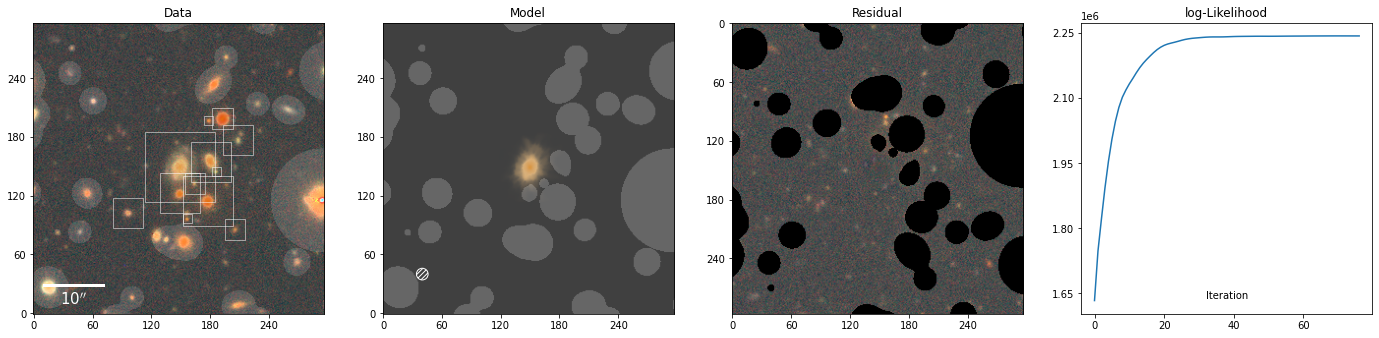

In [9]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=info['sed_ind'], #[0, 1],
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

In [12]:
-2.5 * np.log10(blend.get_model().sum(axis=(1, 2))) + 27

array([20.55517 , 19.534536, 18.695316, 18.258545], dtype=float32)

In [1296]:
with open(f"./Model/NSA/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, _mask = dill.load(fp)
    fp.close()

In [1297]:
info['sed_ind']

array([0])

In [1298]:
import statmorph

In [1299]:
components = np.array(blend.sources)[info['sed_ind']]
observation = blend.observations[0]
aggr_mask = _mask.astype(bool)

In [1300]:
min_cutout_size = max([comp.bbox.shape[1] for comp in components])
# Multi-components enabled
_blend = scarlet.Blend(components, observation)
lower_left = np.min([np.array(comp.bbox.origin) for comp in components], axis=0)
upper_right = np.max([np.array(comp.bbox.origin) + np.array(comp.bbox.shape) for comp in components], axis=0)
bbox = scarlet.Box(upper_right - lower_left, origin=lower_left)
bbox.center = np.array(bbox.origin) + np.array(bbox.shape) // 2
bbox.shape = tuple(int(i * 1.5) for i in bbox.shape)
bbox.origin = tuple(bbox.center[i] - bbox.shape[i] // 2 for i in range(3))

models = _blend.get_model()  # PSF-free model
models = observation.render(models)  # PSF-convoled model
models = models[:, bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
        bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
data = observation.data
weights = observation.weights
psfs = observation.psf.get_model()
if aggr_mask is None:
    mask = (weights.sum(axis=0) == 0)
else:
    mask = aggr_mask | (weights.sum(axis=0) == 0)

data = data[:, bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
data = np.ascontiguousarray(data)
mask = mask[bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
mask = np.ascontiguousarray(mask)
weights = weights[:, bbox.origin[1]:bbox.origin[1] +
                  bbox.shape[1], bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
weights = np.ascontiguousarray(weights)

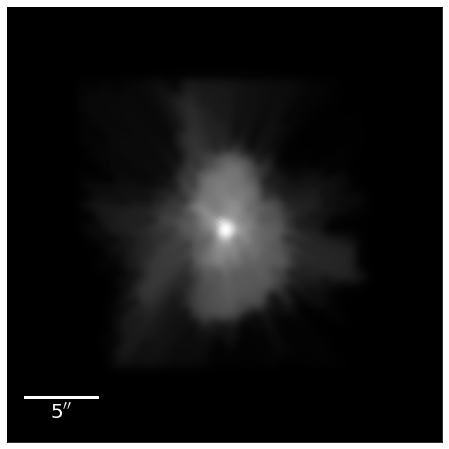

In [1301]:
display_single(models[0], scale='linear', cmap='Greys_r');

In [1312]:
# We take the model and weight map in g-band. Such that we can use the SED to get
# surface brightness in other bands.
# A sky background is estimated on the original image,
# and we run `sep` to generate a 1-sigma segmentation map.
# Then we run `statmorph` using that segmap
sigma = 2

filt = 0
img = models[filt] # data[filt]#
bkg = sep.Background(data[filt], bh=12, bw=12, mask=mask) # 
_, segmap = sep.extract(img - bkg.globalback, sigma, err=bkg.globalrms, minarea=1,
                        deblend_cont=1,
                        mask=mask, segmentation_map=True)

mask = np.copy(segmap)

# cen_ind = [segmap[int(comp.center[0] - comp.bbox.origin[1]), 
#                   int(comp.center[1] - comp.bbox.origin[2])] for comp in components]
cen_ind = [segmap[int(bbox.center[1] - bbox.origin[1]), 
                  int(bbox.center[2] - bbox.origin[2])] for comp in components]
segmap[~np.add.reduce([segmap == ind for ind in cen_ind]).astype(bool)] = 0

segmap = (segmap > 0)
segmap = convolve(segmap, Gaussian2DKernel(4)) > 0.01

mask[~np.add.reduce([mask != ind for ind in cen_ind]).astype(bool)] = 0
mask = (mask > 0)
mask = convolve(mask, Gaussian2DKernel(1)) > 0.002
# bkg = sep.Background(img, bh=15, bw=15, mask=None) # 
#img -= bkg.globalback
# img -= bkg.back()

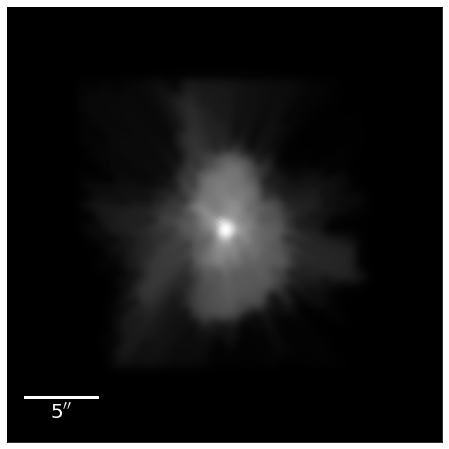

In [1313]:
display_single(img, scale='linear', cmap='Greys_r');

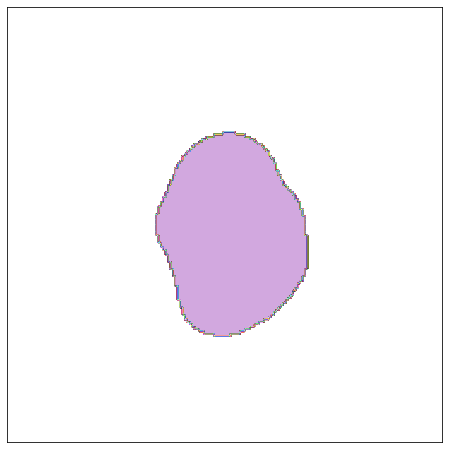

In [1314]:
display_single(segmap.astype(float), cmap=SEG_CMAP, scale='linear');

In [1315]:
# img[~segmap] = np.nan

In [1316]:
# segmap = np.ones_like(img) # no segmap

In [1317]:
source_morphs = statmorph.source_morphology(
    img, segmap, weightmap=np.sqrt(weights[filt]),
    n_sigma_outlier=10, min_cutout_size=min_cutout_size, 
    cutout_extent=2.5,
    skybox_size=14,
    #petro_extent_cas=1,
    #petro_fraction_gini=0.1,
    mask=mask, 
    psf=psfs[filt])
morph = source_morphs[0]

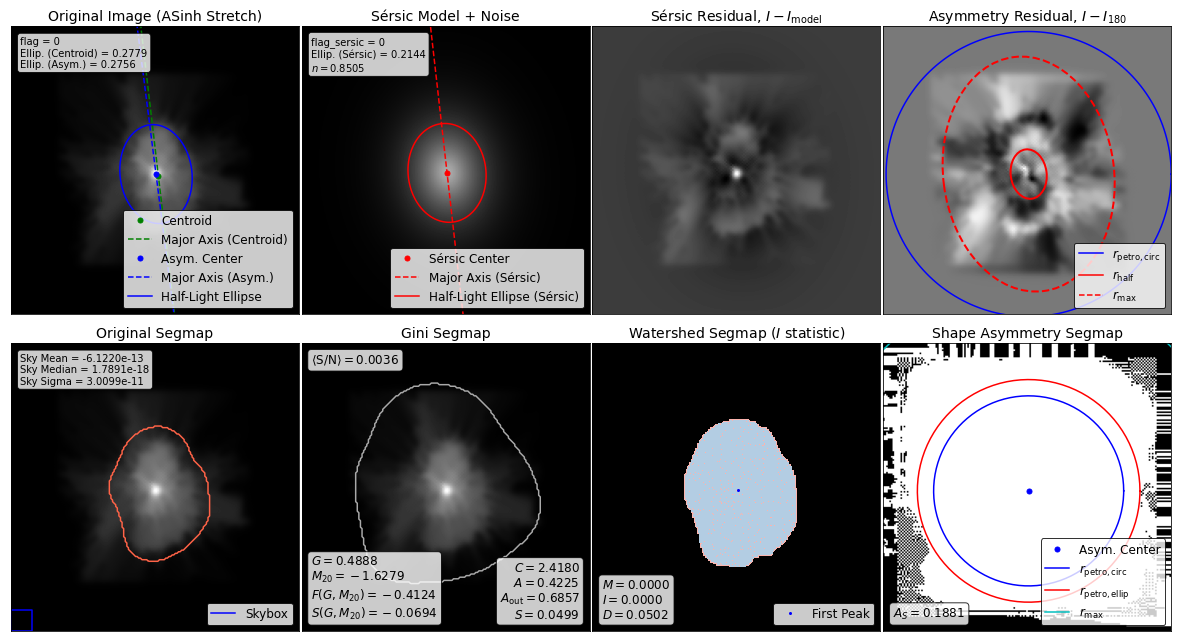

In [1318]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph, asinh_a=0.8)

In [1282]:
morph.orientation_asymmetry

-0.3572499963316194

In [71]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1013.fits')
lsbg = lsbg_cat[np.where(lsbg_cat['viz-id'] == 5798)[0]][0]

In [158]:
with open(f"./Model/NSA/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

In [159]:
from kuaizi.measure import makeMeasurement

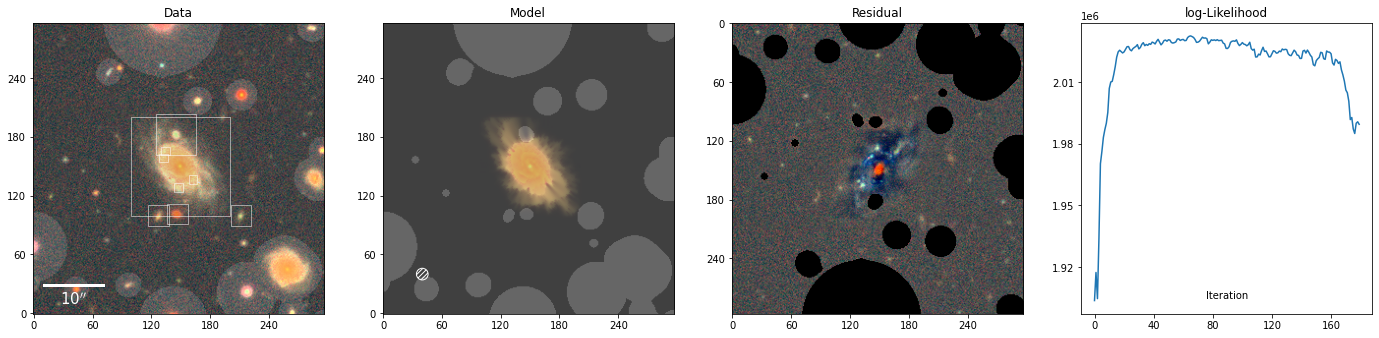

In [160]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=info['sed_ind'],
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

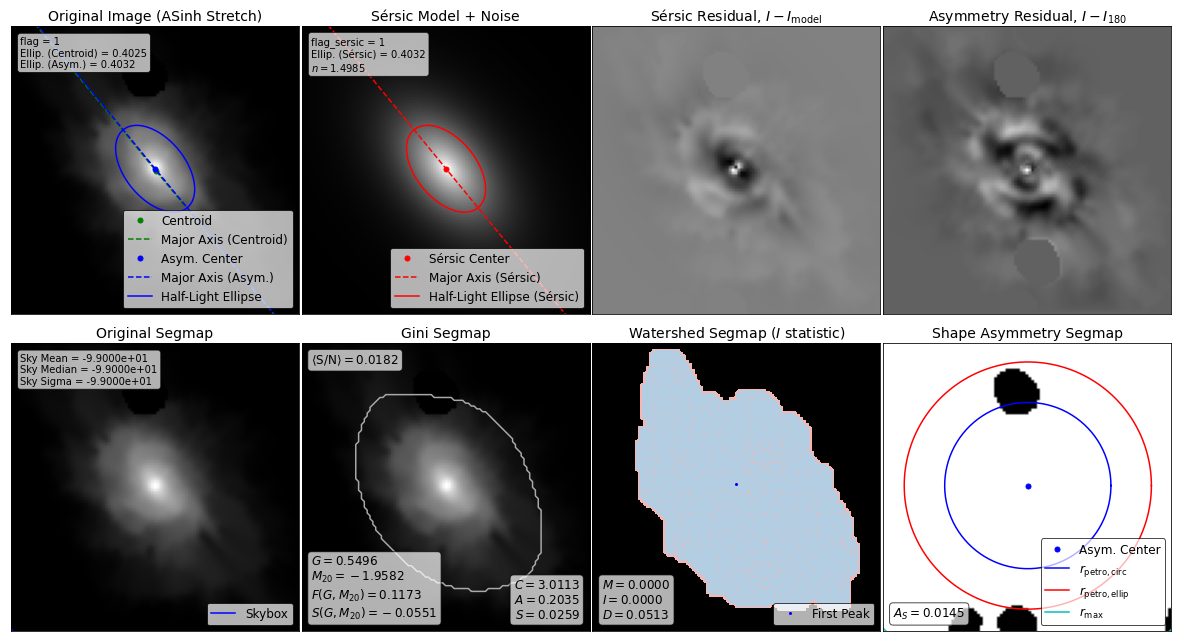

In [163]:
measurement, morph = makeMeasurement(blend.sources[0:1], #list(np.array(blend.sources)[info['sed_ind']]),
                                                blend.observations[0], 
                                                aggr_mask=mask.astype(bool), 
                                                makesegmap=False, #sigma=1,
                                                zeropoint=27.0, out_prefix=None, 
                                                show_fig=True, framealpha=0.7)

In [45]:
### Surface brightness

In [58]:
import photutils

In [90]:
image = morph._cutout_stamp_maskzeroed
r = morph.rhalf_circ
r_in = r - 0.5 * morph._annulus_width
r_out = r + 0.5 * morph._annulus_width

center = morph._asymmetry_center

circ_annulus = photutils.CircularAnnulus(center, r_in, r_out)

In [91]:
circ_annulus

<CircularAnnulus([171.849924  , 170.35016515], r_in=54.434000639315535, r_out=55.434000639315535)>

In [97]:
circ_annulus.do_photometry(image, method='exact')[0][0] / _aperture_area(circ_annulus, morph._mask_stamp)

0.10588904779862689

In [83]:
from statmorph.statmorph import _aperture_area

In [111]:
morph.SB_eff_ellip

0.1326720991633661

In [101]:
morph.SB_circ(30)

0.2309987992763701

In [102]:
morph.SB_circ(54)

0.1088485801924251

In [ ]:
## Central SB

In [169]:
image = morph._cutout_stamp_maskzeroed
center = morph._peak


In [176]:
SB_set = []
r_set = np.logspace(-1, 1, 25)
for r in r_set: 
    #r = 1 #morph.rhalf_circ
    circ_aper = photutils.CircularAperture(center, r)
    SB_set.append(circ_aper.do_photometry(image)[0][0] / circ_aper.area)

In [184]:
morph.SB_circ(1)

1.455276766395422

In [187]:
morph.SB_0_circ

array(2.31020329)

In [186]:
morph.SB_0_ellip

array(2.31018508)

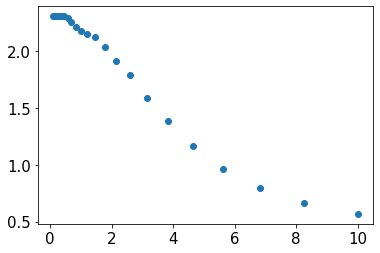

In [172]:
plt.scatter(np.logspace(-1, 1, 25), SB_set)

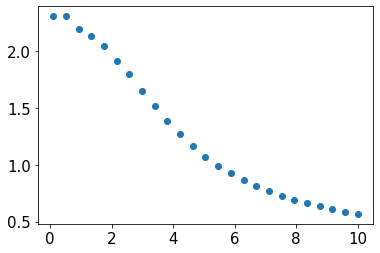

In [174]:
plt.scatter(np.linspace(0.1, 10, 25), SB_set)

In [191]:
from kuaizi import old_measure

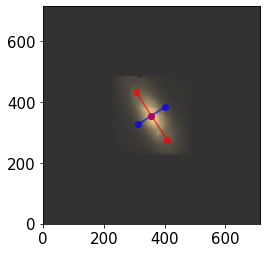

In [193]:
temp = old_measure.makeMeasurement(blend.sources[:1], observation, show_fig=True)

In [194]:
temp

{'x_cen': 356.64375168299165,
 'y_cen': 354.828377799406,
 'ra_cen': 192.23917417411988,
 'dec_cen': -0.7823414415960165,
 'x_cen_winpos': 357.55937458888684,
 'y_cen_winpos': 353.7215505902157,
 'ra_cen_winpos': 192.23913144106703,
 'dec_cen_winpos': -0.7823930935323838,
 'flux': array([1842.1173, 3056.3464, 3860.015 , 4216.0483], dtype=float32),
 'mag': array([18.836708, 18.286995, 18.033527, 17.937737], dtype=float32),
 'R50': array([11.73221851, 11.73221914, 11.73221971, 11.7322193 ]),
 'q': array([0.55651472, 0.55651472, 0.55651472, 0.55651472]),
 'pa': array([-56.94883183, -56.94883183, -56.94883184, -56.94883183]),
 'SB0': array([23.972975, 23.423262, 23.169796, 23.074005], dtype=float32),
 'SB0_winpos': array([24.399937, 23.850224, 23.596756, 23.500965], dtype=float32)}

In [197]:
-2.5 * np.log10(morph.SB_0_ellip / (0.168**2)) + 27.0

22.217429472498406

In [196]:
morph.SB_0_circ

array(2.31020329)

In [287]:
from scarlet.wavelet import get_multiresolution_support

In [288]:
src = blend.sources[0]
img = src.get_model()[0]

In [231]:
detect_image = src.get_model()[0]
sigma = 0.1
# Find the wavelet coefficients
coeffs = scarlet.Starlet(detect_image, lvl=5).coefficients[0]
# Determine the significant coefficients
# (as defined in Starck et. al 2011)
M = get_multiresolution_support(detect_image, coeffs, sigma, K=3, epsilon=1e-1, max_iter=20)
# Use the multi-resolution support to select only
# the relevant pixels for detection
detect = M * coeffs
# We are only detecting positive peaks, so there
# is no need to include the negative coefficients
detect[detect<0] = 0

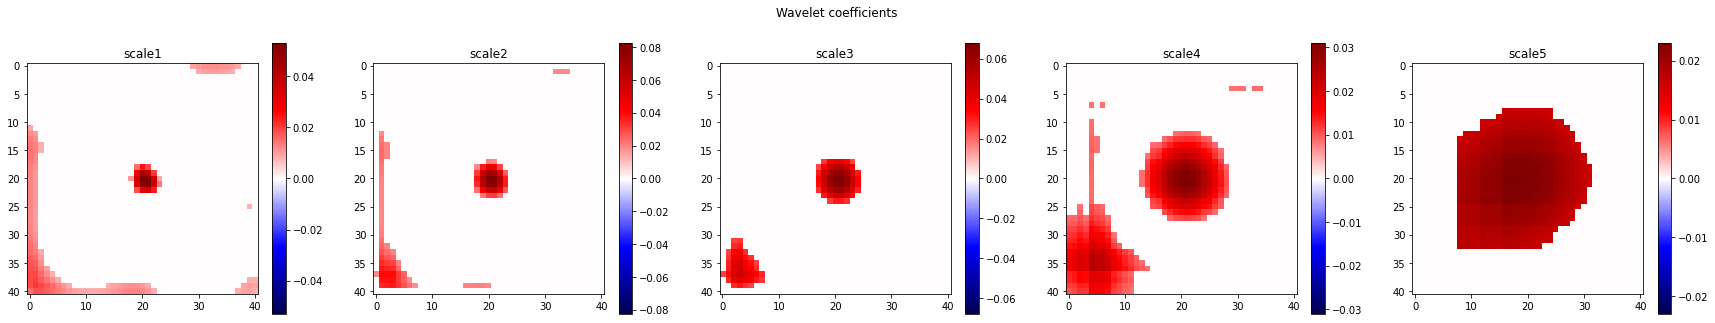

In [23]:
# Display the detection coefficients
lvl = detect.shape[0]
plt.figure(figsize = (lvl*5+5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    img = detect[i]
    img = np.arcsinh(10*img)/10
    vmax = np.max(np.abs(img))
    plt.imshow(img, cmap="seismic", vmin=-vmax, vmax=vmax)
    plt.colorbar()
plt.show()

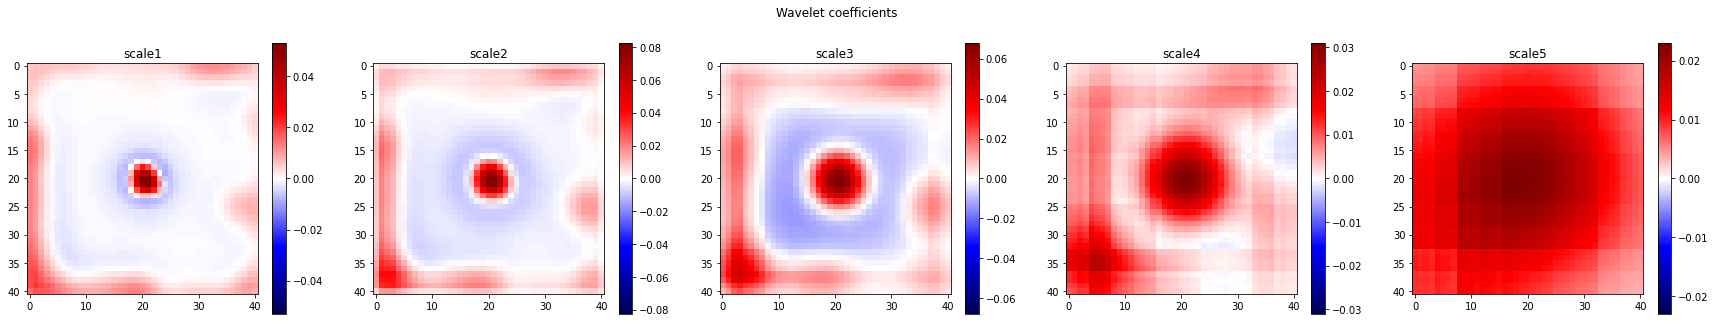

In [24]:
# Display the detection coefficients
lvl = detect.shape[0]
plt.figure(figsize = (lvl*5+5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    img = coeffs[i]
    img = np.arcsinh(10*img)/10
    vmax = np.max(np.abs(img))
    plt.imshow(img, cmap="seismic", vmin=-vmax, vmax=vmax)
    plt.colorbar()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i in range(6):
    axes[i//3, i%3] = display_single(detect[i], ax=axes[i//3, i%3], scale_bar=False, scale='linear')